In [1]:
%config InlineBackend.figure_format='retina'

In [2]:
# %pip install ..

In [3]:
from pyTrajectory.data_structures import TimestampedInstanceCollection, Trajectory
from pyTrajectory.reidentification import assign_identities
from pyTrajectory.features import position, posture_segments
from pyTrajectory.visualization import get_trajectory_range
from pyTrajectory.config import cfg

In [ ]:
cfg.trajectory_keys = ("keypoints", "timestamp", "identity")
cfg.key_keypoints, cfg.key_timestamp, cfg.key_identity = cfg.trajectory_keys

In [4]:
import _pickle
import numpy as np

def load_pickle(file_name):
    with open(file_name, 'rb') as fid:
        dump = _pickle.load(fid)
    return dump

def load_trajectories_pickle(trajectory_file, trial_id, renumber=False):
    trajectories_legacy = load_pickle(trajectory_file)
    trajectories = {}
    for idx, i in enumerate(sorted(trajectories_legacy['IDENTITIES'])):
        data = {cfg.key_time_stamp: trajectories_legacy[str(i)]['FRAME_IDX'],
                cfg.key_keypoints: trajectories_legacy[str(i)]['KEYPOINTS']}
        trajectory = Trajectory().load(data=data)
        trajectories[trial_id + '.' + str(idx + 1 if renumber else i)] = trajectory
    return trajectories

def tracks_to_pooled(tracks):
    assert 'IDENTITIES' in tracks and 'FRAME_IDX' in tracks, 'Tracks should be in track dictionary format'
    pooled = {}
    for i in tracks['IDENTITIES']:
        if len(pooled) == 0:
            pooled = {key: [] for key in tracks[str(i)]}
            pooled['IDENTITY'] = []
        for key in tracks[str(i)]:
            pooled[key].append(tracks[str(i)][key])
        pooled['IDENTITY'].append(np.repeat(i, tracks[str(i)][key].shape[0]).astype(int))
    for key in pooled:
        pooled[key] = np.concatenate(pooled[key], axis=0)
    return pooled

In [17]:
predictions = tracks_to_pooled(load_pickle("/media/paul/Data/predictions_GH030419.MP4_reencode.pkl"))

In [19]:
data = TimestampedInstanceCollection(
    data={
        "keypoints": predictions["KEYPOINTS"],
        "timestamp": predictions["FRAME_IDX"],
        "identity": np.repeat("", len(predictions["FRAME_IDX"])).astype(np.dtypes.StringDType()),
    },
)

In [12]:
data = assign_identities(data, position_func=position, max_lag=30, max_distance=100)

  0%|          | 0/21210 [00:00<?, ?it/s]

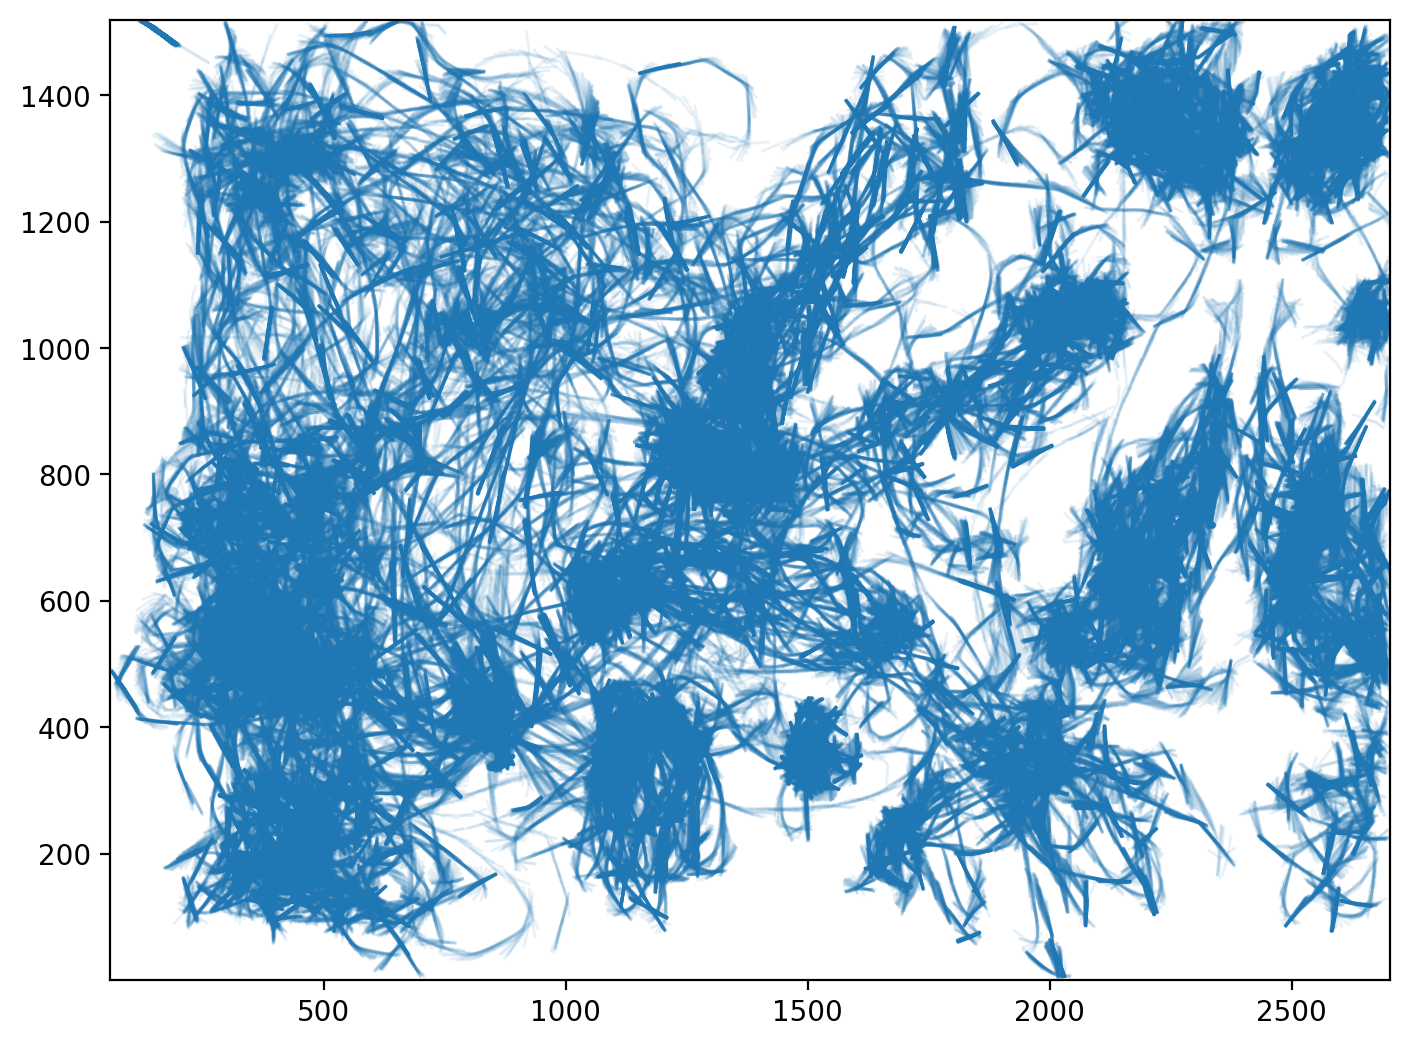

In [14]:
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

lim = defaultdict(list)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

for identity in np.unique(data["identity"]):
    
    trajectory = Trajectory(data=data.select(identity=identity).data, validate_on_init=False)
    segments = posture_segments(trajectory, keypoint_pairs=((0, 1), (1, 2)))
    ax.add_collection(LineCollection(segments.reshape(-1, 2, 2), lw=1, alpha=0.1))
    x_lim, y_lim = get_trajectory_range(trajectory)
    lim["x_min"].append(x_lim[0])
    lim["x_max"].append(x_lim[1])
    lim["y_min"].append(y_lim[0])
    lim["y_max"].append(y_lim[1])

ax.set_ylim(min(lim["y_min"]), max(lim["y_max"]))
ax.set_xlim(min(lim["x_min"]), max(lim["x_max"]))
plt.show()